In [1]:
import tutorenvs
from tutorenvs.utils import DataShopLogger
from tutorenvs.multicolumn_std import MultiColumnAddition
from tutorenvs.trainer import AuthorTrainer

In [2]:
edge_case_set = [
    ["777", "777"],
    ["773", "773"],
    ["737", "737"],
    ["377", "377"],
    ["337", "337"],
    ["733", "733"], # missing in CHI2020
    ["333", "333"], # missing in CHI2020
    ["999", "001"],
    ["999", "010"],
    ["999", "100"],
    ["999", "111"],
    ["999", "011"],
    ["999", "110"],
    ["999", "101"],
]

training_set = [
    ["534", "698"],
    ["872", "371"],
    ["839", "445"],
    ["287", "134"],
    ["643", "534"],
    ["248", "137"],
    ["234", "142"],
    ["539", "461"],
    ["433", "576"],
    ["764", "335"],
    ["533", "698"],
]

extra = [
    # ["777", "777"],
    # ["999", "101"],
    # ["999", "111"],
    # ["999", "001"],
]

In [3]:
def log_completeness(agent, profile='ground_truth.txt', log=[]):
    completeness = agent.eval_completeness(profile)
    print("CMPLEETNESS", completeness)
    log.append(completeness)


def run_training(agent, logger_name='MulticolumnAddition', n=100,
                 n_columns=3, author_train=True, carry_zero=False, fixed_train_set=False):
    logger = DataShopLogger(logger_name, extra_kcs=['field'])
    problem_set = training_set + extra + training_set   #[["777", "777"], ["666", "666"], ["777","777"]]

    env = MultiColumnAddition(check_how=False, check_args=True,
            demo_args=True, demo_how=False, n_digits=n_columns,
            carry_zero=carry_zero)

    # make_completeness_profile(env, training_set+edge_case_set, 'exp_z_ground_truth.txt')
    kwargs = dict(problem_set=problem_set) if fixed_train_set else dict(n_problems=n)
    trainer = AuthorTrainer(agent, env, logger=logger,
                **kwargs)#, n_problems=n)
    c_log = []
    profile = "exp_z_ground_truth.txt" if carry_zero else "ground_truth.txt"
    trainer.on_problem_end = lambda : log_completeness(agent, profile, log=c_log)

    # else:
    #     env = MultiColumnAddition(check_how=False, check_args=False, demo_args=True, demo_how=True, n_digits=n_columns)
    #     trainer = Trainer(agent, env, logger=logger, problem_set=problem_set, n_problems=n)
    trainer.start()
    for i, obj in enumerate(c_log):
        print(f"corr={obj['correctness']*100:2.2f}%, compl={obj['completeness']*100:.2f}%")
    return c_log
    
def train_active_learning(agent, logger_name='MulticolumnAddition', n=100,
                 n_columns=3, carry_zero=False, fixed_train_set=False):
    logger = DataShopLogger(logger_name, extra_kcs=['field'])
    env = MultiColumnAddition(check_how=False, check_args=True,
            demo_args=True, demo_how=True, n_digits=n_columns,
            carry_zero=carry_zero)
    
    rand_problems = []
    for i in range(100):
        prob_config = env.set_random_problem()
        rand_problems.append(prob_config)
        
    p = rand_problems[0]
    
    c_log = []
    for i in range(100):
        profile = "exp_z_ground_truth.txt" if carry_zero else "ground_truth.txt"
        trainer = AuthorTrainer(agent, env, logger=logger, problem_set=[p])#, n_problems=n)
        trainer.on_problem_end = lambda : log_completeness(agent, profile, log=c_log)
        trainer.start()
        
        certainties = []
        for _p in rand_problems:
            
            env.set_problem(*_p)
            out = agent.act_rollout(env.get_state())
            print(f"CERTAINTY {_p}", out['avg_certainty'])
            certainties.append(out['avg_certainty'])
            
        import numpy as np
        p = rand_problems[np.argmin(certainties)]
    return c_log
            

In [15]:
from apprentice.agents.cre_agents.cre_agent import CREAgent
agent_args = {
    "search_depth" : 2,
    "where_learner": "antiunify",
    #"where_learner": "mostspecific",
    # "when_learner": "sklearndecisiontree",    
    "explanation_choice" : "least_operations",
    
    "planner" : "setchaining",
    "function_set" : ["OnesDigit","TensDigit","Add","Add3"],
    "feature_set" : [],
    #"feature_set" : ['Equals'],
    
    "extra_features" : ["SkillCandidates","Match"],
    "find_neighbors" : True,
    "when_args": {"encode_relative" : True, "one_hot" : True, "check_sanity" : False},
}

dt_args = {
    "when_learner": "decisiontree",
}
stand_args = {
    "when_learner": "stand",
    "which_learner": "when_prediction",
    "action_chooser" : "max_which_utility",
    "suggest_uncert_neg" : True,
}

stand_relaxed_args = {**stand_args,
    "when_args" : {
        **agent_args['when_args'],
        "split_choice" : "all_near_max"
    }
}

import numpy as np
import matplotlib.pyplot as plt

markers = ['+', '.', 'o']
def plot_cmp(d, title):
    for i, (label, prof) in enumerate(d.items()):
        
        cmp = [d['completeness'] for d in prof]
        plt.plot(np.arange(1,len(cmp)+1), cmp, label=label)#, marker=markers[i])
    plt.title(title)
    plt.xlabel('Problem #')
    plt.ylabel('Post-Problem Completeness')
    plt.legend(loc="lower right")
    plt.ylim(-0.05, 1.05)
    plt.axhline(1.0, linestyle='--', color="#dddddd99")
    plt.show()



In [5]:
agent = CREAgent(**agent_args, **stand_args)
log_stand_active = train_active_learning(agent)

STARTING PROBLEM 294_382
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(b.value) + f8(b.value) + f8(b.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(a.value) + f8(a.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + (f8(b.value) + f8(b.value) + f8(b.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(a.value) + f8(b.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + 

/home/danny/.local/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/danny/.local/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


	_declare_skill_cands: 706.930664 ms
WILL LEARN False 0.0
fit option_tree: 36.51 ms
fit_spec_ext: 6.96 ms
HINT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
EXPLAIN DEMO!
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f175ede2b80>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_rk3Gi(OnesDigit(a + b)) s(OnesDigit(f8(a.value) + f8(b.value)))
WILL LEARN False 0.0
fit option_tree: 0.07 ms
fit_spec_ext: 0.01 ms
EXPLAIN DEMO!
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f175ede2b80>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CH

CERTAINTY ('189', '908') 0.35714285714285715
CERTAINTY ('812', '770') 0.35714285714285715
CERTAINTY ('689', '250') 0.35714285714285715
CERTAINTY ('584', '150') 0.36363636363636365
CERTAINTY ('408', '509') 0.35714285714285715
CERTAINTY ('791', '512') 0.37012987012987014
CERTAINTY ('256', '757') 0.36363636363636365
CERTAINTY ('917', '602') 0.36363636363636365
CERTAINTY ('134', '943') 0.36363636363636365
CERTAINTY ('430', '209') 0.35714285714285715
CERTAINTY ('242', '906') 0.36363636363636365
CERTAINTY ('189', '352') 0.37012987012987014
CERTAINTY ('980', '132') 0.36363636363636365
CERTAINTY ('435', '977') 0.35714285714285715
CERTAINTY ('190', '957') 0.36363636363636365
CERTAINTY ('428', '133') 0.35714285714285715
CERTAINTY ('110', '935') 0.35714285714285715
CERTAINTY ('472', '149') 0.35714285714285715
CERTAINTY ('806', '268') 0.35714285714285715
CERTAINTY ('105', '742') 0.36363636363636365
CERTAINTY ('382', '118') 0.35714285714285715
CERTAINTY ('965', '436') 0.35714285714285715
CERTAINTY 

	_declare_skill_cands: 687.082031 ms
WILL LEARN False 0.0
fit option_tree: 0.08 ms
fit_spec_ext: 0.01 ms
INCORRECT: done -> {'value': -1}
HINT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 0.49 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 0.22 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 2.0
fit option_tree: 0.11 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 2.0
fit option_tree: 0.13 ms
fit_spec_ext: 0.01 ms
CORRECT: out2 -> {'value': '3'}
INCORRECT: out3 -> {'value': '6'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
WILL LEARN True 2.0
fit option_tree: 0.11 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 42.0
fit option_tree: 0.14 ms
fit_spec_ext: 0.01 ms
INCORRECT: out4 -> {'value': '1'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished 

foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'inpB2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'carry1', 'inpB2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry1', 'inpB2', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match True ['carry1', 'inpA2', 'inpB2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
Any FOCI MATCH True
NumericalToStr(TensDigit(Add3(CastFloat(a.value), CastFloat(b.value), CastFloat(c.value))))
------------------v-------------------
AND(Sel:=Var(TextField), Sel.locked == 0, Sel.locked == 0, Sel.value == '',


CERTAINTY ('461', '597') 0.6327143384586451
CERTAINTY ('992', '824') 0.6361192983474772
CERTAINTY ('734', '418') 0.884312564715606
CERTAINTY ('587', '656') 0.7545719243965601
CERTAINTY ('116', '492') 0.5154206612754477
CERTAINTY ('617', '332') 0.4939610851475796
CERTAINTY ('785', '336') 0.6706663973900668
CERTAINTY ('266', '972') 0.6986474313661857
CERTAINTY ('549', '606') 0.5513077932809868
CERTAINTY ('231', '897') 0.6352974995785681
CERTAINTY ('983', '145') 0.6346829842927549
CERTAINTY ('679', '897') 0.6151470675206374
CERTAINTY ('847', '241') 0.49213758787659406
CERTAINTY ('394', '433') 0.5197527591367245
CERTAINTY ('473', '853') 0.5674469644685288
CERTAINTY ('458', '611') 0.48829088134736187
CERTAINTY ('741', '887') 0.6367324481184641
CERTAINTY ('761', '839') 0.9748627039254923
CERTAINTY ('686', '373') 0.6312769203354011
CERTAINTY ('642', '869') 0.6360157224992282
CERTAINTY ('480', '127') 0.5417405210590476
CERTAINTY ('902', '579') 0.6415919072586358
CERTAINTY ('257', '105') 0.8848

CERTAINTY ('181', '826') 0.9221373472646965
CERTAINTY ('108', '174') 0.9265330280218231
CERTAINTY ('375', '880') 0.8523895096325586
STARTING PROBLEM 274_560
WILL LEARN True 157.0
fit option_tree: 4.43 ms
fit_spec_ext: 0.12 ms
WILL LEARN True 169.64285714285714
fit option_tree: 0.77 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 7013.2467532467535
fit option_tree: 5.95 ms
fit_spec_ext: 0.16 ms
WILL LEARN True 1589.5555555555557
fit option_tree: 4.41 ms
fit_spec_ext: 0.18 ms
INCORRECT: carry3 -> {'value': '0'}
CORRECT: out1 -> {'value': '4'}
INCORRECT: carry2 -> {'value': '1'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 358.85714285714283
fit option_tree: 3.33 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 2949056.544891641
fit option_tree: 6.91 ms
fit_spec_ext: 0.20 ms
WILL LEARN True 105465.02868068834
fit option_tree: 4.82 ms
fit_spec_ext: 0.18 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_mat

Correctness : 81.52%
Completeness : 48.91%
return_diffs False
CMPLEETNESS {'completeness': 0.4891304347826087, 'correctness': 0.8152173913043478}
TOTALS  (correct:4, incorrect:4, hint:0, assistance:4)
PERCENTS(correct:50.00%, incorrect:50.00%, hint:0.00%, assistance:50.00%)
CERTAINTY ('294', '382') 0.9928080872913991
CERTAINTY ('491', '864') 0.9741892502258356
CERTAINTY ('843', '793') 0.898013705463049
CERTAINTY ('495', '186') 0.9762636392811297
CERTAINTY ('452', '742') 0.9751873246802643
CERTAINTY ('981', '795') 0.858747984483192
CERTAINTY ('678', '931') 0.8322190370611303
CERTAINTY ('310', '335') 0.9720693671848999
CERTAINTY ('725', '376') 0.7937040569499592
CERTAINTY ('174', '269') 0.8135558701508637
CERTAINTY ('909', '565') 0.9774831514762515
CERTAINTY ('797', '687') 0.8883420047911105
CERTAINTY ('970', '204') 0.6359695659241131
CERTAINTY ('709', '439') 0.7937858223761035
CERTAINTY ('317', '415') 0.717154425479032
CERTAINTY ('322', '599') 0.5910710912965627
CERTAINTY ('307', '546')

Correctness : 78.26%
Completeness : 56.52%
return_diffs False
CMPLEETNESS {'completeness': 0.5652173913043478, 'correctness': 0.782608695652174}
TOTALS  (correct:7, incorrect:4, hint:3, assistance:7)
PERCENTS(correct:50.00%, incorrect:28.57%, hint:21.43%, assistance:50.00%)
CERTAINTY ('294', '382') 0.8549967996147771
CERTAINTY ('491', '864') 0.66413511533443
CERTAINTY ('843', '793') 0.6210150331422516
CERTAINTY ('495', '186') 0.9595544135122921
CERTAINTY ('452', '742') 0.6611512158553541
CERTAINTY ('981', '795') 0.5880088535423654
CERTAINTY ('678', '931') 0.7097437147349912
CERTAINTY ('310', '335') 0.721556872230791
CERTAINTY ('725', '376') 0.9199669283431973
CERTAINTY ('174', '269') 0.9191215148255121
CERTAINTY ('909', '565') 0.7881470772231618
CERTAINTY ('797', '687') 0.960074787385768
CERTAINTY ('970', '204') 0.6743300594783264
CERTAINTY ('709', '439') 0.8021561495924783
CERTAINTY ('317', '415') 0.8826730037177934
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 0.8853469185489

CERTAINTY ('382', '118') 0.8587228475223927
CERTAINTY ('965', '436') 0.8184239694822413
CERTAINTY ('554', '427') 0.8790578996721835
CERTAINTY ('421', '356') 0.8592388691114259
CERTAINTY ('556', '288') 0.8030165794404973
CERTAINTY ('630', '329') 0.7127540180648709
CERTAINTY ('305', '508') 0.7794387972132493
CERTAINTY ('859', '934') 0.6971495874987542
CERTAINTY ('105', '871') 0.8874465677646467
CERTAINTY ('734', '752') 0.9832709598455962
CERTAINTY ('670', '279') 0.5773055710045356
CERTAINTY ('127', '439') 0.821443480097132
CERTAINTY ('986', '160') 0.8338804261372276
CERTAINTY ('354', '213') 0.9818057713129031
CERTAINTY ('947', '941') 0.5533997941226411
CERTAINTY ('629', '677') 0.8245262301816573
CERTAINTY ('870', '247') 0.8019107073935586
CERTAINTY ('262', '873') 0.8383263699458031
CERTAINTY ('681', '402') 0.6243177886351727
CERTAINTY ('131', '720') 0.685541783218715
CERTAINTY ('649', '229') 0.6173042462538566
CERTAINTY ('171', '347') 0.7002721290736754
CERTAINTY ('543', '972') 0.7031431

CERTAINTY ('288', '761') 0.9804397336098676
CERTAINTY ('812', '415') 0.9745371965334623
CERTAINTY ('110', '680') 0.9853275274517229
CERTAINTY ('856', '355') 0.9683263751470633
CERTAINTY ('655', '645') 0.9675686329778548
CERTAINTY ('326', '777') 0.9723791908189658
CERTAINTY ('263', '756') 0.8764047348196042
CERTAINTY ('461', '597') 0.9810779976365929
CERTAINTY ('992', '824') 0.9861153986720262
CERTAINTY ('734', '418') 0.9087079243805176
CERTAINTY ('587', '656') 0.8700526248676809
CERTAINTY ('116', '492') 0.982923834275066
CERTAINTY ('617', '332') 0.9809451115501554
CERTAINTY ('785', '336') 0.9757481870123864
CERTAINTY ('266', '972') 0.9830124105231465
CERTAINTY ('549', '606') 0.9068121596552136
CERTAINTY ('231', '897') 0.980795226944041
CERTAINTY ('983', '145') 0.9751813569243597
CERTAINTY ('679', '897') 0.9758392989958827
CERTAINTY ('847', '241') 0.9846784855942377
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 0.8914552240060094
CERTAINTY ('458', '611') 0.9777721253251355
CERTA

WILL LEARN True 263.0
fit option_tree: 5.58 ms
fit_spec_ext: 0.07 ms
CORRECT: carry2 -> {'value': '1'}
HINT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 24.0
fit option_tree: 7.75 ms
fit_spec_ext: 0.15 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 12.0
fit option_tree: 1.80 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN True 64.0
fit option_tree: 2.45 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 2.0
fit option_tree: 4.73 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 91.30%
Completeness : 81.52%
return_diffs False
CMPLEETNESS {'completeness': 0.8152173913043478, 'correctness': 0.9130434782608695}
TOTALS  (correct:6, incorrect:0, hint:1, assis

CERTAINTY ('491', '864') 0.9770918892473662
CERTAINTY ('843', '793') 0.9908664168394002
CERTAINTY ('495', '186') 0.9830281405315354
CERTAINTY ('452', '742') 0.9878646640284072
CERTAINTY ('981', '795') 0.9799524792883021
CERTAINTY ('678', '931') 0.9828688157319673
CERTAINTY ('310', '335') 0.982747657118653
CERTAINTY ('725', '376') 0.9741155405530427
CERTAINTY ('174', '269') 0.9840206339741682
CERTAINTY ('909', '565') 0.9123364830898231
CERTAINTY ('797', '687') 0.9934106776333331
CERTAINTY ('970', '204') 0.9702224627445241
CERTAINTY ('709', '439') 0.9123672399351003
CERTAINTY ('317', '415') 0.927092890358174
CERTAINTY ('322', '599') 0.9963649581970191
CERTAINTY ('307', '546') 0.9340479338530627
CERTAINTY ('744', '612') 0.9919506473849451
CERTAINTY ('524', '764') 0.9991285403050109
CERTAINTY ('189', '908') 0.902251649320418
CERTAINTY ('812', '770') 0.9747548348752825
CERTAINTY ('689', '250') 0.9898520226437854
CERTAINTY ('584', '150') 0.9850406038664794
CERTAINTY ('408', '509') 0.93526619

CERTAINTY ('382', '118') 0.9777987333036441
CERTAINTY ('965', '436') 0.9849003920475738
CERTAINTY ('554', '427') 0.9552671609295238
CERTAINTY ('421', '356') 0.9193715701719404
CERTAINTY ('556', '288') 0.9875842737482298
CERTAINTY ('630', '329') 0.9914646252376508
CERTAINTY ('305', '508') 0.9901303137625709
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 1.0
CERTAINTY ('734', '752') 0.9921420218551099
CERTAINTY ('670', '279') 1.0
CERTAINTY ('127', '439') 0.988863856863747
CERTAINTY ('986', '160') 0.9785816853241457
CERTAINTY ('354', '213') 0.9650470154026649
CERTAINTY ('947', '941') 1.0
CERTAINTY ('629', '677') 0.9877416715256188
CERTAINTY ('870', '247') 0.9871110367238178
CERTAINTY ('262', '873') 0.9804044604205655
CERTAINTY ('681', '402') 0.9878909485333697
CERTAINTY ('131', '720') 0.9888213853776114
CERTAINTY ('649', '229') 0.9289695409620958
CERTAINTY ('171', '347') 0.9898398504132906
CERTAINTY ('543', '972') 0.9623678498095528
CERTAINTY ('876', '964') 0.9829515855222939
CERTA

CERTAINTY ('980', '132') 0.9822338708268837
CERTAINTY ('435', '977') 0.9805227572526333
CERTAINTY ('190', '957') 0.9879543202430959
CERTAINTY ('428', '133') 0.9660101419574741
CERTAINTY ('110', '935') 0.903504556332829
CERTAINTY ('472', '149') 0.9752492648193037
CERTAINTY ('806', '268') 0.9831028412915699
CERTAINTY ('105', '742') 0.9985564703304388
CERTAINTY ('382', '118') 0.9784165959148154
CERTAINTY ('965', '436') 0.9081592333892968
CERTAINTY ('554', '427') 0.9573252920140086
CERTAINTY ('421', '356') 0.9195173007704659
CERTAINTY ('556', '288') 0.9905776970056964
CERTAINTY ('630', '329') 0.9913564063650271
CERTAINTY ('305', '508') 0.9900355981288239
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 1.0
CERTAINTY ('734', '752') 0.921042777139334
CERTAINTY ('670', '279') 1.0
CERTAINTY ('127', '439') 0.9886228502509153
CERTAINTY ('986', '160') 0.9841278510175239
CERTAINTY ('354', '213') 0.9620467032469386
CERTAINTY ('947', '941') 1.0
CERTAINTY ('629', '677') 0.9159006741807056
CERTAI

CERTAINTY ('327', '342') 0.9591338764652715
CERTAINTY ('288', '761') 0.9424635925984551
CERTAINTY ('812', '415') 0.9834040930707686
CERTAINTY ('110', '680') 0.9904610472853089
CERTAINTY ('856', '355') 0.9840831137570553
CERTAINTY ('655', '645') 0.9096513046076622
CERTAINTY ('326', '777') 0.9145203805366584
CERTAINTY ('263', '756') 0.9857023899562741
CERTAINTY ('461', '597') 0.9744611049499977
CERTAINTY ('992', '824') 0.9886856645765729
CERTAINTY ('734', '418') 0.9869773092284714
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 0.9643067094967049
CERTAINTY ('617', '332') 0.9987198924983938
CERTAINTY ('785', '336') 0.9851459811151702
CERTAINTY ('266', '972') 0.9862850023192664
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 0.9804265880444517
CERTAINTY ('983', '145') 0.9819789172739561
CERTAINTY ('679', '897') 0.9796226045120968
CERTAINTY ('847', '241') 0.9572492914632207
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 0.9875107163424665
CERTAINTY ('458', '611') 0.986040

fit option_tree: 1.38 ms
fit_spec_ext: 0.05 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 8.0
fit option_tree: 4.61 ms
fit_spec_ext: 0.25 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 5.70 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 5.65 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 97.83%
Completeness : 89.13%
return_diffs False
CMPLEETNESS {'completeness': 0.8913043478260869, 'correctness': 0.9782608695652174}
TOTALS  (correct:10, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:90.91%, incorrect:0.00%, hint:9.09%, assistance:9.09%)
CERTAINTY ('294', '382') 0.9968501116712893
CERTAINTY ('491', '864') 0.981303311846226
CERTAINTY ('843', 

Correctness : 98.91%
Completeness : 82.61%
return_diffs False
CMPLEETNESS {'completeness': 0.8260869565217391, 'correctness': 0.9891304347826086}
TOTALS  (correct:13, incorrect:2, hint:1, assistance:3)
PERCENTS(correct:81.25%, incorrect:12.50%, hint:6.25%, assistance:18.75%)
CERTAINTY ('294', '382') 0.9967099797238278
CERTAINTY ('491', '864') 0.9856813930885331
CERTAINTY ('843', '793') 0.9934708954214831
CERTAINTY ('495', '186') 0.8984708834106645
CERTAINTY ('452', '742') 0.9108420852495774
CERTAINTY ('981', '795') 0.98659870186805
CERTAINTY ('678', '931') 0.987148825051749
CERTAINTY ('310', '335') 0.7028443852768048
CERTAINTY ('725', '376') 0.9903986396510777
CERTAINTY ('174', '269') 0.9124068661560252
CERTAINTY ('909', '565') 0.6048001292926304
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 0.9719214300544197
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 0.6639036084878875
CERTAINTY ('322', '599') 0.8572612773664754
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612')

CERTAINTY ('543', '972') 0.9625751800200911
CERTAINTY ('876', '964') 0.7884013302060934
CERTAINTY ('397', '259') 0.9747080612135486
CERTAINTY ('716', '831') 0.9945807879941536
CERTAINTY ('274', '560') 1.0
CERTAINTY ('327', '342') 0.958781605372521
CERTAINTY ('288', '761') 0.9935864070465105
CERTAINTY ('812', '415') 0.6895210980922502
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 0.8106689210257726
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 0.9899335051294036
CERTAINTY ('263', '756') 0.9856868214372412
CERTAINTY ('461', '597') 0.9200520673424402
CERTAINTY ('992', '824') 0.9905553262946944
CERTAINTY ('734', '418') 0.9913130522600201
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 0.9668340018225088
CERTAINTY ('617', '332') 0.9986380759826157
CERTAINTY ('785', '336') 0.7426585104743035
CERTAINTY ('266', '972') 0.9871438736360592
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 0.8003540015891695
CERTAINTY ('983', '145') 0.9845555439508099
CERTAINTY ('679', '8

CERTAINTY ('181', '826') 0.9875478754563805
CERTAINTY ('108', '174') 0.9904287108704793
CERTAINTY ('375', '880') 0.9912872182334156
STARTING PROBLEM 435_977
WILL LEARN True 12.0
fit option_tree: 8.40 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 85802.00226671703
fit option_tree: 16.35 ms
fit_spec_ext: 0.27 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN True 22896.0
fit option_tree: 15.50 ms
fit_spec_ext: 0.27 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 9.0
fit option_tree: 2.36 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'inpB2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.

CERTAINTY ('181', '826') 0.9877887919497831
CERTAINTY ('108', '174') 0.9938088109206742
CERTAINTY ('375', '880') 0.9920225259690703
STARTING PROBLEM 679_897
WILL LEARN True 4.0
fit option_tree: 8.72 ms
fit_spec_ext: 0.10 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 1457669.0317626528
fit option_tree: 17.15 ms
fit_spec_ext: 0.32 ms
CORRECT: out1 -> {'value': '6'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 15984.0
fit option_tree: 9.35 ms
fit_spec_ext: 0.11 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 2.79 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 3150.0
fit option_tree: 5.43 ms
fit_spec_ext: 0.12 ms
CORRECT: out2 -> {'value': '7'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '7'}
WILL LE

WILL LEARN True 6.0
fit option_tree: 3.39 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 2160.0
fit option_tree: 4.79 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 4.82 ms
fit_spec_ext: 0.09 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 1.25 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 194622.9576547231
fit option_tree: 4.10 ms
fit_spec_ext: 0.27 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 7.05 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN True 3.0
fit option_tree: 2.57 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 2.44 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '6'}
APPL

CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 0.9913964821040032
CERTAINTY ('689', '250') 0.9632465373458469
CERTAINTY ('584', '150') 0.9612039344517868
CERTAINTY ('408', '509') 0.9963592149659368
CERTAINTY ('791', '512') 0.81048955033829
CERTAINTY ('256', '757') 0.9926274458088968
CERTAINTY ('917', '602') 1.0
CERTAINTY ('134', '943') 0.9913154027293937
CERTAINTY ('430', '209') 0.9518523457119363
CERTAINTY ('242', '906') 0.9581847876659056
CERTAINTY ('189', '352') 0.9927769372901029
CERTAINTY ('980', '132') 0.9894580407977512
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 0.9948431390659156
CERTAINTY ('428', '133') 0.9640796258024497
CERTAINTY ('110', '935') 0.9974257083822009
CERTAINTY ('472', '149') 0.9951806419551724
CERTAINTY ('806', '268') 0.9952016572774277
CERTAINTY ('105', '742') 1.0
CERTAINTY ('382', '118') 0.9887894053817897
CERTAINTY ('965', '436') 0.9968763196462728
CERTAINTY ('554', '427') 0.9579109220355114
CERTAINTY ('421', '356') 0.9241736538978799
CERTAI

CERTAINTY ('171', '347') 0.9957181258930284
CERTAINTY ('543', '972') 0.9913141115604295
CERTAINTY ('876', '964') 0.9515983148834666
CERTAINTY ('397', '259') 0.9959588294555598
CERTAINTY ('716', '831') 0.9213343277496581
CERTAINTY ('274', '560') 0.9829652346584745
CERTAINTY ('327', '342') 0.9893025885323018
CERTAINTY ('288', '761') 0.990401986865083
CERTAINTY ('812', '415') 0.9896926773362095
CERTAINTY ('110', '680') 0.9917808219178081
CERTAINTY ('856', '355') 0.9513777058995719
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 0.9941301913771207
CERTAINTY ('263', '756') 0.9721707385256617
CERTAINTY ('461', '597') 0.9955238636254516
CERTAINTY ('992', '824') 0.9896114121122043
CERTAINTY ('734', '418') 0.994916074044589
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 0.9965753424657534
CERTAINTY ('617', '332') 0.9896846627241768
CERTAINTY ('785', '336') 0.9929835167407989
CERTAINTY ('266', '972') 0.991432801115474
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 0.996833982

CERTAINTY ('480', '127') 0.9897229500700195
CERTAINTY ('902', '579') 0.995781487736119
CERTAINTY ('257', '105') 0.9925820359561817
CERTAINTY ('181', '826') 0.9923559205244623
CERTAINTY ('108', '174') 0.9934117433171462
CERTAINTY ('375', '880') 0.991930573217718
STARTING PROBLEM 681_402
WILL LEARN True 4.0
fit option_tree: 9.18 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 1.39 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '3'}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN True 4.0
fit option_tree: 8.23 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 4.0
fit option_tree: 8.60 ms
fit_spec_ext: 0.07 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 7039.753846153846
fit option_tree: 11.17 ms
fit_s

CERTAINTY ('491', '864') 0.9900185013738753
CERTAINTY ('843', '793') 0.9961558098691109
CERTAINTY ('495', '186') 0.9181896413027495
CERTAINTY ('452', '742') 0.9948358007997596
CERTAINTY ('981', '795') 0.9946463957476545
CERTAINTY ('678', '931') 0.9930466041705116
CERTAINTY ('310', '335') 0.9882588228034178
CERTAINTY ('725', '376') 0.9926970423778002
CERTAINTY ('174', '269') 0.9526467031682669
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 0.8879789832593036
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 0.9673177416794702
CERTAINTY ('322', '599') 0.9227457869889835
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 0.9926490526855871
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 0.9888604550733402
CERTAINTY ('689', '250') 0.9731075683025563
CERTAINTY ('584', '150') 0.9720644384122735
CERTAINTY ('408', '509') 0.9965322745228222
CERTAINTY ('791', '512') 0.9922019298492372
CERTAINTY ('256', '757') 0.8669273

CERTAINTY ('744', '612') 0.9931890054477067
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 0.9904917591833168
CERTAINTY ('689', '250') 0.9583348852998227
CERTAINTY ('584', '150') 0.9556124501718569
CERTAINTY ('408', '509') 0.9963210661988404
CERTAINTY ('791', '512') 0.992491195495556
CERTAINTY ('256', '757') 0.9937246695476062
CERTAINTY ('917', '602') 0.997873471557682
CERTAINTY ('134', '943') 0.9915901440807061
CERTAINTY ('430', '209') 0.9455114863748861
CERTAINTY ('242', '906') 0.9955142515705568
CERTAINTY ('189', '352') 0.9924616190142521
CERTAINTY ('980', '132') 0.9871036527087125
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 0.9925784811693743
CERTAINTY ('428', '133') 0.9588797215833136
CERTAINTY ('110', '935') 0.99501500314184
CERTAINTY ('472', '149') 0.9950475826596499
CERTAINTY ('806', '268') 0.9989703507152746
CERTAINTY ('105', '742') 0.9952153110047848
CERTAINTY ('382', '118') 0.9900951653192994
CERTAINTY ('965', '436') 0.9966820710

CERTAINTY ('741', '887') 0.9985496736765772
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 0.9594103561625945
CERTAINTY ('642', '869') 0.9976713926776741
CERTAINTY ('480', '127') 0.9912096756992956
CERTAINTY ('902', '579') 0.9957225365551341
CERTAINTY ('257', '105') 0.9925373213725605
CERTAINTY ('181', '826') 0.9924309173999117
CERTAINTY ('108', '174') 0.9933567368546622
CERTAINTY ('375', '880') 0.9904415954982311
STARTING PROBLEM 354_213
WILL LEARN True 4.0
fit option_tree: 8.40 ms
fit_spec_ext: 0.07 ms
WILL LEARN False 0.0
fit option_tree: 1.35 ms
fit_spec_ext: 0.03 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 7.87 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN True 4.0
fit option_tree: 8.81 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
WILL LEARN True 160463.53942428034
fit option_tree: 3.02 ms
fi

WILL LEARN False 0.0
fit option_tree: 8.24 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
REPLACING FEEDBACK Skill_ujynz(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 14
WILL LEARN False 0.0
fit option_tree: 2.74 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
TOTALS  (correct:12, incorrect:1, hint:0, assistance:1)
PERCENTS(correct:92.31%, incorrect:7.69%, hint:0.00%, assistance:7.69%)
CERTAINTY ('294', '382') 0.9980149931369442
CERTAINTY ('491', '864') 0.8238825421272885
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 0.9947747112214465
CERTAINTY ('452', '742') 0.99572394

CERTAINTY ('812', '770') 0.9906623544569899
CERTAINTY ('689', '250') 0.9972666939523745
CERTAINTY ('584', '150') 0.9962698622928815
CERTAINTY ('408', '509') 0.9965050346327248
CERTAINTY ('791', '512') 0.9933071437325586
CERTAINTY ('256', '757') 0.9931515159116772
CERTAINTY ('917', '602') 0.9994026284348865
CERTAINTY ('134', '943') 0.9980570338993279
CERTAINTY ('430', '209') 1.0
CERTAINTY ('242', '906') 0.9975703946243328
CERTAINTY ('189', '352') 0.9930198360266491
CERTAINTY ('980', '132') 0.9894298835289335
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 0.9952174385668425
CERTAINTY ('428', '133') 0.9916163410424529
CERTAINTY ('110', '935') 0.9950750450485424
CERTAINTY ('472', '149') 0.9947433013959788
CERTAINTY ('806', '268') 0.9988124435765403
CERTAINTY ('105', '742') 0.9967741935483871
CERTAINTY ('382', '118') 0.9910938879824567
CERTAINTY ('965', '436') 0.9966472677871508
CERTAINTY ('554', '427') 0.9967105639989428
CERTAINTY ('421', '356') 0.9952884867558354
CERTAINTY ('556', 

CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 0.9965927992940184
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 0.9960808668228222
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 0.9979619565217391
CERTAINTY ('617', '332') 0.9973276776246023
CERTAINTY ('785', '336') 0.9922947486752314
CERTAINTY ('266', '972') 0.9987010777606121
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 0.9977111724922442
CERTAINTY ('983', '145') 0.9907222295472152
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 0.9993961352657005
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 0.9980538398650087
CERTAINTY ('458', '611') 0.9926020722646159
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 0.9948373647728608
CERTAINTY ('642', '869') 0.9988169613804132
CERTAINTY ('480', '127') 0.9955746203571566
CERTAINTY ('902', '579') 0.9957881259274988
CERTAINTY ('257', '105') 0.9931959659589735
CERTAINTY ('181', '826') 0.9971160855315904
CERTAINTY ('108', '1

WILL LEARN False 0.0
fit option_tree: 9.64 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.02 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 0.9979852200983387
CERTAINTY ('491', '864') 0.9932160938575745
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 0.9969474349350538
CERTAINTY ('452', '742') 0.9975108493293432
CERTAINTY ('981', '795') 0.9971904609068356
CERTAINTY ('678', '931') 0.993493797338674
CERTAINTY ('310', '335') 0.9929520088717965
CERT

CERTAINTY ('806', '268') 1.0
CERTAINTY ('105', '742') 0.9977272727272727
CERTAINTY ('382', '118') 0.9951887213471462
CERTAINTY ('965', '436') 0.9964936329141586
CERTAINTY ('554', '427') 0.9966298346183896
CERTAINTY ('421', '356') 0.9972501394311211
CERTAINTY ('556', '288') 1.0
CERTAINTY ('630', '329') 0.9972501394311211
CERTAINTY ('305', '508') 1.0
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 0.996590909090909
CERTAINTY ('734', '752') 1.0
CERTAINTY ('670', '279') 0.9992897727272727
CERTAINTY ('127', '439') 0.9990539262062441
CERTAINTY ('986', '160') 1.0
CERTAINTY ('354', '213') 1.0
CERTAINTY ('947', '941') 1.0
CERTAINTY ('629', '677') 1.0
CERTAINTY ('870', '247') 0.9971727454132098
CERTAINTY ('262', '873') 0.9995265151515151
CERTAINTY ('681', '402') 1.0
CERTAINTY ('131', '720') 0.9945909090909091
CERTAINTY ('649', '229') 1.0
CERTAINTY ('171', '347') 0.9967000297323506
CERTAINTY ('543', '972') 0.9983916253979483
CERTAINTY ('876', '964') 1.0
CERTAINTY ('397', '259') 0.9984042553

Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
TOTALS  (correct:10, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 0.9985185185185185
CERTAINTY ('491', '864') 0.9989881080306612
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 0.9968763657274297
CERTAINTY ('452', '742') 0.9974510738756277
CERTAINTY ('981', '795') 0.997099777694055
CERTAINTY ('678', '931') 0.9949060322244475
CERTAINTY ('310', '335') 0.9977011494252874
CERTAINTY ('725', '376') 0.9962548262548262
CERTAINTY ('174', '269') 0.9964381828637148
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 0.9975438273310614
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 0.9985734083312955
CERTAINTY ('524', '764') 1.0
CERTAINTY 

CERTAINTY ('554', '427') 0.9985569985569985
CERTAINTY ('421', '356') 0.9988505747126437
CERTAINTY ('556', '288') 1.0
CERTAINTY ('630', '329') 0.9988505747126437
CERTAINTY ('305', '508') 1.0
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 0.9965517241379309
CERTAINTY ('734', '752') 1.0
CERTAINTY ('670', '279') 0.9992816091954023
CERTAINTY ('127', '439') 0.9990215264187867
CERTAINTY ('986', '160') 1.0
CERTAINTY ('354', '213') 1.0
CERTAINTY ('947', '941') 1.0
CERTAINTY ('629', '677') 1.0
CERTAINTY ('870', '247') 0.9970921994003196
CERTAINTY ('262', '873') 0.9995210727969349
CERTAINTY ('681', '402') 1.0
CERTAINTY ('131', '720') 0.9945315221177289
CERTAINTY ('649', '229') 1.0
CERTAINTY ('171', '347') 0.9976671610431344
CERTAINTY ('543', '972') 0.9983861830433681
CERTAINTY ('876', '964') 1.0
CERTAINTY ('397', '259') 0.9983516483516484
CERTAINTY ('716', '831') 1.0
CERTAINTY ('274', '560') 1.0
CERTAINTY ('327', '342') 0.9988505747126437
CERTAINTY ('288', '761') 0.9952880215805537
CERTAIN

fit option_tree: 19.12 ms
fit_spec_ext: 0.23 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 3.0
fit option_tree: 3.33 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 540.0
fit option_tree: 5.79 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 5.49 ms
fit_spec_ext: 0.07 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.63 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.72 ms
fit_spec_ext: 0.11 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 4.0
fit option_tree: 9.59 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.56 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
+++

CERTAINTY ('870', '247') 0.9975354030501089
CERTAINTY ('262', '873') 1.0
CERTAINTY ('681', '402') 1.0
CERTAINTY ('131', '720') 1.0
CERTAINTY ('649', '229') 1.0
CERTAINTY ('171', '347') 0.9983368347338936
CERTAINTY ('543', '972') 0.9988651102464332
CERTAINTY ('876', '964') 1.0
CERTAINTY ('397', '259') 0.9983333333333334
CERTAINTY ('716', '831') 1.0
CERTAINTY ('274', '560') 1.0
CERTAINTY ('327', '342') 0.9988095238095237
CERTAINTY ('288', '761') 0.9952365524753963
CERTAINTY ('812', '415') 0.9985216308745721
CERTAINTY ('110', '680') 0.9964285714285716
CERTAINTY ('856', '355') 0.9974603174603175
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 0.9987137383689108
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 0.9995039682539683
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 0.9992559523809523
CERTAINTY ('617', '332') 0.9988095238095237
CERTAINTY ('785', '336') 0.9961740558292281
CERTAINTY ('266', '972') 1.0
CERTAIN

fit option_tree: 10.75 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.77 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:10, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 0.9984350547730829
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 0.9993386243386243
CERTAINTY ('981', '795') 0.9969701980118647
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 0.9976190476190476
CERTAINTY ('725', '376') 0.9961095360039022
CERTAINTY ('174', '269') 0.9962445464029971
CERTAINT

CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 0.9988095238095237
CERTAINTY ('734', '752') 1.0
CERTAINTY ('670', '279') 1.0
CERTAINTY ('127', '439') 0.9989868287740629
CERTAINTY ('986', '160') 1.0
CERTAINTY ('354', '213') 1.0
CERTAINTY ('947', '941') 1.0
CERTAINTY ('629', '677') 1.0
CERTAINTY ('870', '247') 0.9974559337757798
CERTAINTY ('262', '873') 1.0
CERTAINTY ('681', '402') 1.0
CERTAINTY ('131', '720') 1.0
CERTAINTY ('649', '229') 1.0
CERTAINTY ('171', '347') 0.9983300264550264
CERTAINTY ('543', '972') 0.9988651102464332
CERTAINTY ('876', '964') 1.0
CERTAINTY ('397', '259') 0.9982658959537571
CERTAINTY ('716', '831') 1.0
CERTAINTY ('274', '560') 1.0
CERTAINTY ('327', '342') 0.9988095238095237
CERTAINTY ('288', '761') 1.0
CERTAINTY ('812', '415') 0.9985155790711348
CERTAINTY ('110', '680') 0.9964285714285716
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 0.9995039682539683
CERTAINTY

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:5, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 0.9983896940418681
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 0.9969168319313129
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 0.9975757575757577
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 0.9985004944112751
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 0.9970177194251196
CERTAINTY ('584', '150') 1.0
CERTAINTY ('

CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 0.9992378048780488
CERTAINTY ('617', '332') 0.998780487804878
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 0.9988676501933559
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 0.9994918699186992
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 0.9993190330268983
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 0.9980620155038759
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 689_250
WILL LEARN False 0.0
fit option_tree: 10.64 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 1.67 ms
fit_spec_ext: 0.03 ms
CORRECT: out1 -> {'value

CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 0.9980094626154088
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 0.9987730061349694
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 0.9984829148535961
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0
CERTAINTY ('917', '602') 1.0
CERTAINTY ('134', '943') 0.9991645781119465
CERTAINTY ('430', '209') 1.0
CERTAINTY ('242', '906') 1.0
CERTAINTY ('189', '352') 1.0
CERTAINTY ('980', '132') 1.0
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 0.99802761341222

CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 0.999485596707819
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 0.9993164730006835
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 0.9979919678714859
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 190_957
WILL LEARN False 0.0
fit option_tree: 1.85 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 12.27 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 11.00 ms
fit_spec_ext: 0.07 ms
WILL LEARN False 0.0
fit option_tree: 20.94 ms
fit_spec_ext: 0.24 ms
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 20.79 ms
fit_spec_ext: 0.24 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.1

CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0
CERTAINTY ('917', '602') 1.0
CERTAINTY ('134', '943') 0.9991645781119465
CERTAINTY ('430', '209') 1.0
CERTAINTY ('242', '906') 1.0
CERTAINTY ('189', '352') 1.0
CERTAINTY ('980', '132') 1.0
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 1.0
CERTAINTY ('428', '133') 0.9989258861439312
CERTAINTY ('110', '935') 1.0
CERTAINTY ('472', '149') 1.0
CERTAINTY ('806', '268') 1.0
CERTAINTY ('105', '742') 0.9987654320987656
CERTAINTY ('382', '118') 1.0
CERTAINTY ('965', '436') 1.0
CERTAINTY ('554', '427') 0.9992559523809524
CERTAINTY ('421', '356') 0.9987654320987656
CERTAINTY ('556', '288') 1.0
CERTAINTY ('630', '329') 0.9987654320987656
CERTAINTY ('305', '508') 1.0
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 0.9987654320987656
CERTAINTY ('734', '752') 1.0
CERTAINTY ('670', '279') 1.0
CERTAINTY ('127', '439') 

WILL LEARN False 0.0
fit option_tree: 12.43 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTA

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0


CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 134_943
WILL LEARN False 0.0
fit option_tree: 1.66 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 12.58 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 12.38 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 12.39 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 6048.0
fit option_tree: 21.54 ms
fit_spec_ext: 0.23 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 21.55 ms
fit_spec_ext: 0.23 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.69 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '

CERTAINTY ('262', '873') 1.0
CERTAINTY ('681', '402') 1.0
CERTAINTY ('131', '720') 1.0
CERTAINTY ('649', '229') 1.0
CERTAINTY ('171', '347') 1.0
CERTAINTY ('543', '972') 1.0
CERTAINTY ('876', '964') 1.0
CERTAINTY ('397', '259') 1.0
CERTAINTY ('716', '831') 1.0
CERTAINTY ('274', '560') 1.0
CERTAINTY ('327', '342') 1.0
CERTAINTY ('288', '761') 1.0
CERTAINTY ('812', '415') 1.0
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 0.9993638676844784
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0

CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0
CERTAINTY ('917', '602') 1.0
CERTAINTY ('134', '943') 1.0
CERTAINTY ('430', '209') 1.0
CERTAINTY ('242', '906') 1.0
CERTAINTY ('189', '352') 1.0
CERTAINTY ('980', '132') 1.0
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 1.0
CERTAINTY ('428', '133') 1.0
CERTAINTY ('110', '935') 1.0
CERTAINTY ('472', '149') 1.0
CERTAINTY ('806', '268') 1.0
CERTAINTY ('105', '742') 1.0
CERTAINTY ('382', '118') 1.0
CERTAINTY ('965', '436') 1.0
CERTAINTY ('554', '427') 1.0
CERTAINTY ('421', '356') 1.0
CERTAINTY ('556', '288') 1.0
CERTAINTY ('630', '329') 1.0
CERTAINTY ('305', '508') 1.0
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 1.0
CERTAINTY ('73

fit option_tree: 25.58 ms
fit_spec_ext: 0.29 ms
CORRECT: out2 -> {'value': '7'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '7'}
REPLACING FEEDBACK Skill_1d3eC(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 25.62 ms
fit_spec_ext: 0.27 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
REPLACING FEEDBACK Skill_ujynz(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 91
WILL LEARN False 0.0
fit option_tree: 4.58 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_2mRse(a + b + c)(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.42 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '6'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
REPLACING FEEDBACK Skill_TBT14(-1)(done) -> SAI(done, PressButton, {'value': 

CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0
CERTAINTY ('917', '602') 1.0
CERTAINTY ('134', '943') 1.0
CERTAINTY ('430', '209') 1.0
CERTAINTY ('242', '906') 1.0
CERTAINTY ('189', '352') 1.0
CERTAINTY ('980', '132') 1.0
CERTAINTY ('435', '977') 1.0
CERTAINTY ('190', '957') 1.0
CERTAINTY ('428', '133') 1.0
CERTAINTY ('110', '935') 1.0
CERTAINTY ('472', '149') 1.0
CERTAINTY ('806', '268') 1.0
CERTAINTY ('105', '742') 1.0
CERTAINTY ('382', '118') 1.0
CERTAINTY ('965', '436') 1.0
CERTAINTY ('554', '427') 1.0
CERTAINTY ('421', '356') 1.0
CERTAINTY ('556', '288') 1.0
CERTAINTY ('630', '329') 1.0
CERTAINTY ('305', '508') 1.0
CERTAINTY ('859', '934') 1.0
CERTAINTY ('105', '871') 1.0
CERTAINTY ('734', '752') 1.0
CERTAINTY ('670', '279') 1.0
CERTAINTY ('12

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0


CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 158
WILL LEARN False 0.0
fit option_tree: 14.51 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_46wpM(a + b)(out1, inpA1, inpB1) -> SAI(out1, Updat

fit option_tree: 14.07 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1

CERTAINTY ('812', '415') 1.0
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b)

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0


CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 158
WILL LEARN False 0.0
fit option_tree: 13.50 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_46wpM(a + b)(out1, inp

fit option_tree: 13.64 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1

CERTAINTY ('288', '761') 1.0
CERTAINTY ('812', '415') 1.0
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK

APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '

CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 158


Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0


CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 158
WILL LEARN False 0.0
fit option_tree: 13.96 ms
fit_spec_ext: 0.10 ms
REPLACING FEEDBACK Skill_46wpM(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1

fit option_tree: 13.80 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1

CERTAINTY ('288', '761') 1.0
CERTAINTY ('812', '415') 1.0
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0


CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 158
WILL LEARN False 0.0
fit option_tree: 16.70 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_46wpM(a + b)(out1, inpA1, inpB1) -> SAI(out1, Updat

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1.0
CERTAINTY ('524', '764') 1.0
CERTAINTY ('189', '908') 1.0
CERTAINTY ('812', '770') 1.0
CERTAINTY ('689', '250') 1.0
CERTAINTY ('584', '150') 1.0
CERTAINTY ('408', '509') 1.0
CERTAINTY ('791', '512') 1.0
CERTAINTY ('256', '757') 1.0


CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 158
WILL LEARN False 0.0
fit option_tree: 13.03 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_46wpM(a + b)(out1, inpA1, inpB1) -> SAI(out1, Updat

fit option_tree: 13.89 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1

CERTAINTY ('812', '415') 1.0
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b)

fit option_tree: 13.65 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('294', '382') 1.0
CERTAINTY ('491', '864') 1.0
CERTAINTY ('843', '793') 1.0
CERTAINTY ('495', '186') 1.0
CERTAINTY ('452', '742') 1.0
CERTAINTY ('981', '795') 1.0
CERTAINTY ('678', '931') 1.0
CERTAINTY ('310', '335') 1.0
CERTAINTY ('725', '376') 1.0
CERTAINTY ('174', '269') 1.0
CERTAINTY ('909', '565') 1.0
CERTAINTY ('797', '687') 1.0
CERTAINTY ('970', '204') 1.0
CERTAINTY ('709', '439') 1.0
CERTAINTY ('317', '415') 1.0
CERTAINTY ('322', '599') 1.0
CERTAINTY ('307', '546') 1.0
CERTAINTY ('744', '612') 1

CERTAINTY ('812', '415') 1.0
CERTAINTY ('110', '680') 1.0
CERTAINTY ('856', '355') 1.0
CERTAINTY ('655', '645') 1.0
CERTAINTY ('326', '777') 1.0
CERTAINTY ('263', '756') 1.0
CERTAINTY ('461', '597') 1.0
CERTAINTY ('992', '824') 1.0
CERTAINTY ('734', '418') 1.0
CERTAINTY ('587', '656') 1.0
CERTAINTY ('116', '492') 1.0
CERTAINTY ('617', '332') 1.0
CERTAINTY ('785', '336') 1.0
CERTAINTY ('266', '972') 1.0
CERTAINTY ('549', '606') 1.0
CERTAINTY ('231', '897') 1.0
CERTAINTY ('983', '145') 1.0
CERTAINTY ('679', '897') 1.0
CERTAINTY ('847', '241') 1.0
CERTAINTY ('394', '433') 1.0
CERTAINTY ('473', '853') 1.0
CERTAINTY ('458', '611') 1.0
CERTAINTY ('741', '887') 1.0
CERTAINTY ('761', '839') 1.0
CERTAINTY ('686', '373') 1.0
CERTAINTY ('642', '869') 1.0
CERTAINTY ('480', '127') 1.0
CERTAINTY ('902', '579') 1.0
CERTAINTY ('257', '105') 1.0
CERTAINTY ('181', '826') 1.0
CERTAINTY ('108', '174') 1.0
CERTAINTY ('375', '880') 1.0
STARTING PROBLEM 294_382
REPLACING FEEDBACK Skill_rk3Gi(OnesDigit(a + b)

In [7]:
agent = CREAgent(**agent_args, **stand_args)
log_stand = run_training(agent)

STARTING PROBLEM 385_880
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f175ede2b80>, <function Match at 0x7f175ede2b80>, <function Match at 0x7f175ede2b80>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_SnYXE(a + b) s(f8(a.value) + f8(b.value))
WILL LEARN False 0.0
fit option_tree: 0.16 ms
fit_spec_ext: 0.01 ms
HINT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
EXPLAIN DEMO!
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.v

Correctness : 31.52%
Completeness : 21.74%
return_diffs False
CMPLEETNESS {'completeness': 0.21739130434782608, 'correctness': 0.31521739130434784}
STARTING PROBLEM 924_554
WILL LEARN True 3.0
fit option_tree: 0.38 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 4.0
fit option_tree: 0.39 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 2.0
fit option_tree: 0.27 ms
fit_spec_ext: 0.03 ms
INCORRECT: out2 -> {'value': '7'}
INCORRECT: carry2 -> {'value': '0'}
HINT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN True 531.1538461538462
fit option_tree: 0.45 ms
fit_spec_ext: 0.01 ms
WILL L

Correctness : 68.48%
Completeness : 35.87%
return_diffs False
CMPLEETNESS {'completeness': 0.358695652173913, 'correctness': 0.6847826086956522}
STARTING PROBLEM 484_118
WILL LEARN True 388.0
fit option_tree: 2.22 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 5.0
fit option_tree: 1.75 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 45.0
fit option_tree: 0.48 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 31.0
fit option_tree: 2.33 ms
fit_spec_ext: 0.10 ms
CORRECT: carry1 -> {'value': '1'}
CORRECT: out1 -> {'value': '2'}
INCORRECT: out1 -> {'value': '12'}
INCORRECT: out3 -> {'value': '5'}
APPLY: out1 -> {'value': '2'}
WILL LEARN True 97.0
fit option_tree: 2.26 ms
fit_spec_ext: 0.05 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 100.0
fit option_tree: 1.06 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 15.0
fit option_tree: 0.72 ms
fit_spec_ext: 0.02 ms
CORRECT: carry2 -> {'value': '1'}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN True 25.0
fit o

Correctness : 79.35%
Completeness : 65.22%
return_diffs False
CMPLEETNESS {'completeness': 0.6521739130434783, 'correctness': 0.7934782608695652}
STARTING PROBLEM 895_221
WILL LEARN True 928.3396226415093
fit option_tree: 2.91 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 494.0
fit option_tree: 0.73 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 12316.422764227642
fit option_tree: 4.14 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 6680.120689655172
fit option_tree: 5.15 ms
fit_spec_ext: 0.15 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
INCORRECT: carry2 -> {'value': '1'}
INCORRECT: carry1 -> {'value': '0'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 54504.108108108114
fit option_tree: 3.99 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 2544.730769230769
fit option_tree: 2.65 ms
fit_spec_ext: 0.06 ms
WILL LEARN False 0.0
fit option_tree: 3.28 ms
fit_spec_ext: 0.05 ms
CORRECT: carry2 -> {'value': '1'}
CORRECT: out2 -> {'value': '1'}
INCORRECT: carry1 -> {'value': '0'}
APPLY: out2 -> {'

Correctness : 94.57%
Completeness : 76.09%
return_diffs False
CMPLEETNESS {'completeness': 0.7608695652173914, 'correctness': 0.9456521739130435}
STARTING PROBLEM 429_212
WILL LEARN False 0.0
fit option_tree: 4.22 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 105.21052631578947
fit option_tree: 3.00 ms
fit_spec_ext: 0.04 ms
CORRECT: carry1 -> {'value': '1'}
HINT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.20 ms
fit_spec_ext: 0.06 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 6.0


Correctness : 97.83%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9782608695652174}
STARTING PROBLEM 127_643
WILL LEARN False 0.0
fit option_tree: 4.03 ms
fit_spec_ext: 0.05 ms
WILL LEARN False 0.0
fit option_tree: 5.58 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 5.55 ms
fit_spec_ext: 0.10 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 3.0
fit option_tree: 1.49 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN True 11.0
fit option_tree: 3.80 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 1.92 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 3.83 ms
fit_spec_ext: 0.05 ms
CORRECT:

Correctness : 98.91%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9891304347826086}
STARTING PROBLEM 158_489
WILL LEARN False 0.0
fit option_tree: 4.52 ms
fit_spec_ext: 0.04 ms
WILL LEARN False 0.0
fit option_tree: 7.36 ms
fit_spec_ext: 0.14 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 7.34 ms
fit_spec_ext: 0.17 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.65 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 360.0
fit option_tree: 2.68 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 90.0
fit option_tree: 2.65 ms
fit_spec_ext: 0.05 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.62 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '

Correctness : 98.91%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9891304347826086}
STARTING PROBLEM 889_840
WILL LEARN False 0.0
fit option_tree: 5.15 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 108.0
fit option_tree: 0.77 ms
fit_spec_ext: 0.03 ms
CORRECT: out1 -> {'value': '9'}
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 5.0
fit option_tree: 5.11 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 11218.651539708266
fit option_tree: 8.82 ms
fit_spec_ext: 0.13 ms
CORRECT: out2 -> {'value': '2'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
WILL LEARN True 1872.0
fit option_tree: 8.87 ms
fit_spec_ext: 0.14 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1

Correctness : 98.91%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 0.9891304347826086}
STARTING PROBLEM 800_587
WILL LEARN False 0.0
fit option_tree: 5.65 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 5.67 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 12.0
fit option_tree: 5.64 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 20461.333333333336
fit option_tree: 8.39 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '3'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
WILL LEARN True 576.0
fit option_tree: 8.38 ms
fit_spec_ext: 0.10 ms
CORRECT: carry3 -> {'value': '1'}


Correctness : 98.91%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 0.9891304347826086}
STARTING PROBLEM 149_149
WILL LEARN False 0.0
fit option_tree: 6.74 ms
fit_spec_ext: 0.05 ms
WILL LEARN False 0.0
fit option_tree: 10.19 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 9.45 ms
fit_spec_ext: 0.10 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.20 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 6.70 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 2.60 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 6.80 ms
fit_spec_ext: 0.04 ms
CORREC

Correctness : 98.91%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9891304347826086}
STARTING PROBLEM 882_572
WILL LEARN False 0.0
fit option_tree: 7.52 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 90.0
fit option_tree: 0.82 ms
fit_spec_ext: 0.03 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 7.85 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 576.0
fit option_tree: 10.18 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 10.48 ms
fit_spec_ext: 0.11 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.49 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 120.0
fit option_tree: 3.76 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4

Correctness : 98.91%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9891304347826086}
STARTING PROBLEM 366_380
WILL LEARN False 0.0
fit option_tree: 8.51 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 8.41 ms
fit_spec_ext: 0.05 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 11280.0
fit option_tree: 11.28 ms
fit_spec_ext: 0.12 ms
CORRECT: out2 -> {'value': '4'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 10.92 ms
fit_spec_ext: 0.11 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.62 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '7'}
APPLY: o

Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
STARTING PROBLEM 123_505
WILL LEARN False 0.0
fit option_tree: 9.44 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 9.25 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 9.45 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 3.13 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 57 of 100
Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
STARTING PROBLEM 622_547
WILL LEARN F

WILL LEARN False 0.0
fit option_tree: 13.06 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 3.08 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 2.94 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 63 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 590_161
WILL LEARN False 0.0
fit option_tree: 11.68 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 11.73 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 3072.0
fit option_tree: 13.17 ms
fit_spec_ext: 0.14 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 728_459
WILL LEARN False 0.0
fit option_tree: 12.95 ms
fit_spec_ext: 0.09 ms
WILL LEARN False 0.0
fit option_tree: 14.19 ms
fit_spec_ext: 0.13 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 14.06 ms
fit_spec_ext: 0.14 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.11 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 13.07 ms
fit_spec_ext: 0.10 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 437_435
WILL LEARN False 0.0
fit option_tree: 13.33 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 14.57 ms
fit_spec_ext: 0.14 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 14.38 ms
fit_spec_ext: 0.14 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.45 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 13.96 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 3.72 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 13.42 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 ->

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 688_846
WILL LEARN False 0.0
fit option_tree: 14.73 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 1920.0
fit option_tree: 15.91 ms
fit_spec_ext: 0.14 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 15.81 ms
fit_spec_ext: 0.15 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.72 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 120.0
fit option_tree: 4.90 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 4.67 ms
fit_spec_ext: 0.06 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.50 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 180.0
fit option_tree

fit option_tree: 4.40 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 86 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 839_468
WILL LEARN False 0.0
fit option_tree: 15.94 ms
fit_spec_ext: 0.11 ms
WILL LEARN True 1920.0
fit option_tree: 17.84 ms
fit_spec_ext: 0.17 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 17.09 ms
fit_spec_ext: 0.15 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 60.0
fit option_tree: 5.31 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 3.0
fit option_tree: 4.20 ms
fit_spec_ext: 0.03 ms
CORRECT: carry2 -> {'value': '1'}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 572_920
WILL LEARN False 0.0
fit option_tree: 16.59 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 16.58 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 16.60 ms
fit_spec_ext: 0.11 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 56904.00000000001
fit option_tree: 17.56 ms
fit_spec_ext: 0.17 ms
CORRECT: out3 -> {'value': '4'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 17.66 ms
fit_spec_ext: 0.17 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carr

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 293_513
WILL LEARN False 0.0
fit option_tree: 17.06 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 17.14 ms
fit_spec_ext: 0.12 ms
WILL LEARN False 0.0
fit option_tree: 18.06 ms
fit_spec_ext: 0.14 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 18.21 ms
fit_spec_ext: 0.15 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.61 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 4.65 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 17.09 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 ->

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:825, incorrect:56, hint:43, assistance:99)
PERCENTS(correct:89.29%, incorrect:6.06%, hint:4.65%, assistance:10.71%)
corr=20.65%, compl=16.30%
corr=31.52%, compl=21.74%
corr=43.48%, compl=34.78%
corr=53.26%, compl=19.57%
corr=68.48%, compl=35.87%
corr=63.04%, compl=46.74%
corr=69.57%, compl=52.17%
corr=70.65%, compl=57.61%
corr=79.35%, compl=65.22%
corr=80.43%, compl=65.22%
corr=89.13%, compl=68.48%
corr=90.22%, compl=77.17%
corr=94.57%, compl=76.09%
corr=94.57%, compl=76.09%
corr=95.65%, compl=76.09%
corr=95.65%, compl=76.09%
corr=95.65%, compl=76.09%
corr=92.39%, compl=77.17%
corr=97.83%, compl=91.30%
corr=97.83%, compl=91.30%
corr=93.48%, compl=79.35%
corr=97.83%, compl=86.96%
corr=97.83%, compl=86.96%
corr=98.91%, compl=92.39%
corr=98.91%, compl=92.39%
corr=98.91%, compl=92.39%
corr=98.91%, compl=92.39%
corr=98.91%, compl=92.39%
corr=98

In [11]:
agent = CREAgent(**agent_args, **dt_args)
log_dt = run_training(agent)

STARTING PROBLEM 101_986
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(a.value) + f8(b.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + (f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + TensDigit(f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + TensDigit(f8(a.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + (f8(a.value

Correctness : 20.65%
Completeness : 11.96%
return_diffs False
CMPLEETNESS {'completeness': 0.11956521739130435, 'correctness': 0.20652173913043478}
STARTING PROBLEM 871_101
INCORRECT: done -> {'value': -1}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
EXPLAIN DEMO!
HINT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 3 of 100
Cor

Correctness : 39.13%
Completeness : 11.96%
return_diffs False
CMPLEETNESS {'completeness': 0.11956521739130435, 'correctness': 0.391304347826087}
STARTING PROBLEM 346_214
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
INCORRECT: out1 -> {'value': '10'}
APPLY: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
INCORRECT: out2 -> {'value': '5'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT

Correctness : 68.48%
Completeness : 38.04%
return_diffs False
CMPLEETNESS {'completeness': 0.3804347826086957, 'correctness': 0.6847826086956522}
STARTING PROBLEM 715_746
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
INCORRECT: out2 -> {'value': '5'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '6'}
INCORRECT: carry2 -> {'value': '0'}
INCORRECT: out2 -> {'value': '5'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: out2 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out3 -> {'val

Correctness : 91.30%
Completeness : 78.26%
return_diffs False
CMPLEETNESS {'completeness': 0.782608695652174, 'correctness': 0.9130434782608695}
STARTING PROBLEM 224_674
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
CORRECT: out2 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 16 of 100
Correctness : 86.96%
Completeness : 70.65%
return_diffs False
CMPLEETNESS {'completeness': 0.7065217391304348, 'correctness': 0.8695652173913043}
STARTING PROBLEM 371_788
CORRECT: out1 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '1'}
INCORRECT: out3 -> {'value': '10'}
APPLY: out1 -> {'value': '9'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_ma

Correctness : 92.39%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.9239130434782609}
STARTING PROBLEM 536_709
CORRECT: out1 -> {'value': '5'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '5'}
INCORRECT: carry2 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 21 of 100
Correctness : 95.65%
Completeness

Correctness : 95.65%
Completeness : 80.43%
return_diffs False
CMPLEETNESS {'completeness': 0.8043478260869565, 'correctness': 0.9565217391304348}
STARTING PROBLEM 760_589
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 28 of 100
Correctness : 95.65%
Completeness : 86.96%
return_diffs False
CMPLEET

Correctness : 98.91%
Completeness : 85.87%
return_diffs False
CMPLEETNESS {'completeness': 0.8586956521739131, 'correctness': 0.9891304347826086}
STARTING PROBLEM 312_550
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
CORRECT: out3 -> {'value': '8'}
INCORRECT: carry3 -> {'value': '0'}
APPLY: out3 -> {'value': '8'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 36 of 100
Correctness : 94.57%
Completeness : 67.39%
return_diffs False
CMPLEETNESS {'completeness': 0.6739130434782609, 'correctness': 0.9456521739130435}
STARTING PROBLEM 586_625
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'v

Correctness : 98.91%
Completeness : 80.43%
return_diffs False
CMPLEETNESS {'completeness': 0.8043478260869565, 'correctness': 0.9891304347826086}
STARTING PROBLEM 797_627
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
+++++++++++++++++++++++++++++++++++

Correctness : 98.91%
Completeness : 82.61%
return_diffs False
CMPLEETNESS {'completeness': 0.8260869565217391, 'correctness': 0.9891304347826086}
STARTING PROBLEM 845_996
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '8'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '8'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
+++++++++++++++++++++++++++++++++++

Correctness : 98.91%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.9891304347826086}
STARTING PROBLEM 243_491
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 58 of 100
Correctness : 97.83%
Completeness : 86.96%
return_diffs False
CMPLEETNESS {'completeness': 0.8695652173913043, 'correctness': 0.9782608695652174}
STARTING PROBLEM 384_275
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value':

CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 65 of 100
Correctness : 97.83%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9782608695652174}
STARTING PROBLEM 102_636
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished probl

Correctness : 100.00%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 1.0}
STARTING PROBLEM 245_715
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '6'}
INCORRECT: out3 -> {'value': '9'}
APPLY: out2 -> {'value': '6'}
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 73 of 100
Correctness : 100.00%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 1.0}
STARTING PROBLEM 145_846
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: carry1 -> {

Correctness : 100.00%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 1.0}
STARTING PROBLEM 222_672
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 80 of 100
Correctness : 98.91%
Completeness : 79.35%
return_diffs False
CMPLEETNESS {'completeness': 0.7934782608695652, 'correctness': 0.9891304347826086}
STARTING PROBLEM 199_907
INCORRECT: carry3 -> {'value': '1'}
CORRECT: out1 -> {'value': '6'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
AP

Correctness : 98.91%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 0.9891304347826086}
STARTING PROBLEM 655_489
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
INCORRECT: out2 -> {'value': '13'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}


Correctness : 100.00%
Completeness : 85.87%
return_diffs False
CMPLEETNESS {'completeness': 0.8586956521739131, 'correctness': 1.0}
STARTING PROBLEM 196_268
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '6'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '6'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 94 of 100
Correctness : 98.91%
Completeness : 83.70%
return_diffs False
CMPLEETNESS {'completeness': 0.8369565217391305, 'correctness': 0.9891304347826086}

Correctness : 100.00%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 1.0}
TOTALS  (correct:966, incorrect:112, hint:38, assistance:150)
PERCENTS(correct:86.56%, incorrect:10.04%, hint:3.41%, assistance:13.44%)
corr=19.57%, compl=19.57%
corr=20.65%, compl=11.96%
corr=22.83%, compl=14.13%
corr=39.13%, compl=11.96%
corr=33.70%, compl=16.30%
corr=50.00%, compl=22.83%
corr=50.00%, compl=22.83%
corr=51.09%, compl=10.87%
corr=68.48%, compl=38.04%
corr=75.00%, compl=28.26%
corr=91.30%, compl=67.39%
corr=89.13%, compl=65.22%
corr=92.39%, compl=88.04%
corr=89.13%, compl=59.78%
corr=91.30%, compl=78.26%
corr=86.96%, compl=70.65%
corr=90.22%, compl=67.39%
corr=95.65%, compl=72.83%
corr=93.48%, compl=78.26%
corr=92.39%, compl=69.57%
corr=95.65%, compl=75.00%
corr=94.57%, compl=70.65%
corr=93.48%, compl=67.39%
corr=94.57%, compl=79.35%
corr=96.74%, compl=85.87%
corr=96.74%, compl=86.96%
corr=95.65%, compl=80.43%
corr=95.65%, compl=86.96%
corr

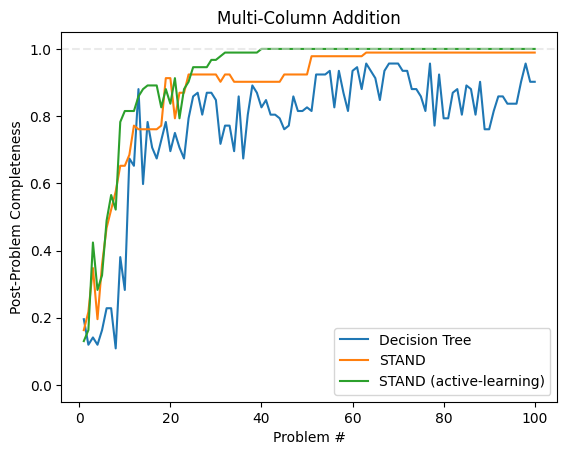

In [16]:
plot_cmp({"Decision Tree" : log_dt, "STAND": log_stand, "STAND (active-learning)" : log_stand_active, }, "Multi-Column Addition")